# In this notebook I will:
* Go through and remove reviews that only have advertisements? (NOT AT THIS TIME)
* Tokenize, lemmatize, remove stop words, and remove instances of words that only show up once that aren't special (words that indicate a condition, medication, side effect, or caregiver role)
* Rejoin processed review into a string for BOW analysis

In [1]:
import pandas as pd
import numpy as np
import glob

# Haven't decided whether I like nltk or spacy better yet
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet, stopwords
stops = stopwords.words('english')
import spacy
import en_core_web_lg
nlp = en_core_web_lg.load()

# A method to process text in nltk:
# https://pythonhealthcare.org/2018/12/14/101-pre-processing-data-tokenization-stemming-and-removal-of-stop-words/

# same process in spacy
# https://spacy.io/usage/linguistic-features

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Just don't have time to learn these right now
#from sklearn.base import TransformerMixin
#from sklearn.pipeline import Pipeline

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
# Adjusting stop words in spacy to not lose a bunch of negatives for the sentiment analysis
for word in [u'nor',u'none',u'not',u'alone',u'no',u'never',u'cannot',u'always']:
    nlp.vocab[word].is_stop = False
nlp.vocab[u'thing'].is_stop = True

# Working on processing text data

In [176]:
def spacyTokenizer(s: str)-> list:
    doc = nlp(s.lower().strip())
    tokens = []
    for token in doc:
        if not token.is_stop and token.is_alpha and token.lemma_ != '-PRON-':
            tokens.append(token.lemma_)
        
    return tokens

def getSynonyms(word):
    #https://www.geeksforgeeks.org/get-synonymsantonyms-nltk-wordnet-python/
    synonyms = []
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonyms+= spacyTokenizer(l.name().replace('_', ' ').lower())
           
    return list(set(synonyms))

# Setting a very basic metric for uniqueness to test a new way to quantify side effect presence
def quantify_uniqueness(word):
    syns = getSynonyms(word)
    #print(syns)
    return len(syns+[word])**-1

In [177]:
# Idea:
# In each sentence:
#    1. Look for all nouns
#    2. Look for all adjectives
#    3. Count a hit if has at least:
#          - One noun and one adjective for side effects that have each
#          - Whole side effect for one word side effects --> Give these synonyms and allow one hit
#          - Two nouns for side effects with only nouns?
# See what this produces for short list of reviews

In [201]:
# Initializing the count vectorizer
vectorizer = CountVectorizer()

# Parsing side effects
def parseSideEffects_basic(file):
    # Loading in the file I curated
    sideEff = np.genfromtxt(file, delimiter='$', dtype=str)

    cleanedSEs = []
    uniqueness = []
    for SE in sideEff:
        if len(SE.strip().split(' ')) == 1:
            cleanedSEs.append(' '.join(list(set(getSynonyms(SE.strip().lower())))))
        else:
            cleanedSEs.append(' '.join(list(set(spacyTokenizer(SE)))))
        uniqueness.append([quantify_uniqueness(word) for word in spacyTokenizer(cleanedSEs[-1])])
    
    return cleanedSEs, uniqueness

# Haven't implemented this idea yet
#     posSEs = []
#     for cSE in cleanedSEs:
#         posSEs.append([token.pos_ for token in nlp(cSE)])

def parseReviewSentences_basic(file):
    reviews = pd.read_csv(file, sep='$')['Comment']
    
    return reviews
    
#     cleanedRevs = [[' '.join(spacyTokenizer(sent)) for sent in rev.split('.')] for rev in reviews]

#     return cleanedRevs

def findSideEffects_basic(seFile, revFile):
    # Parsing side effects and reviews
    cleanedSEs, uniqSEs = parseSideEffects_basic(seFile)
    cleanedRevs = parseReviewSentences_basic(revFile)
    
    
    # For each sentence in each review
    tracer = {}
    for i,rev in enumerate(cleanedRevs):
        tracer[i] = {}
        for j,cSE in enumerate(cleanedSEs):
            concern = cSE.strip().split(' ')
            vectorizer.vocabulary = concern
            X = vectorizer.fit_transform(rev).toarray()
            result = (X*np.array(uniqSEs[j])[-1,None]).sum(axis=1)
#             result = (X > 0).sum(axis=1)
#             if len(concern) > 2:
#                 result = result > np.ceil(len(concern) / 2)
#             else:
#                 result = result == len(concern)
            tracer[i][cSE] = result
            
    return tracer, cleanedSEs, cleanedRevs

In [202]:
# findings, SEs, Revs = findSideEffects_basic('SideEffects/ADHD_SideEffects.csv',
#                                            'ProcessedReviews/ADHD/Bupropion_ADHD_parsed_reviews.csv')

revs = parseReviewSentences_basic('ProcessedReviews/ADHD/Bupropion_ADHD_parsed_reviews.csv')

In [211]:
SEs
#revs.loc[45]

['abdominal cramp stomach',
 'acid sour stomach',
 'taste unpleasant bad unusual peculiar',
 'eruct eructation belch bubble erupt extravasate burp',
 'big black eye pupil dilated enlarge',
 'blurred vision',
 'skin darken',
 'pinch jerk flip nip vellication twinge twitch tweet squeeze',
 'black tongue',
 'bloat',
 'change sense taste',
 'constipation irregularity impairment deaden stultification',
 'urination decrease frequency',
 'volume decrease urine',
 'decrease appetite',
 'sexual desire interest decrease libido loss ability',
 'diarrhea looseness diarrhoea bowel',
 'have poope movement difficulty bowel',
 'difficulty move',
 'dribble difficulty pass urine',
 'dizziness lightheadedness giddiness vertigo',
 'dry mouth',
 'dry burn itching eye',
 'breast enlargement',
 'urinate frequent need',
 'feeling general illness discomfort',
 'loss hair',
 'pyrosis heartburn',
 'rash nettle urtication beehive urticaria hive',
 'inability erection',
 'increase performance desire drive libido s

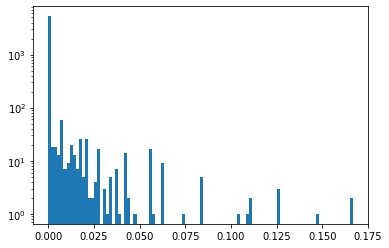

In [195]:
# for i in findings:
#     for j in findings[i]:
#         if findings[i][j].sum() > 0.25: print(findings[i][j].sum(), j, '\n', Revs[i], '\n\n')
        
scores = []
revs = {}
for i in findings:
    revs['. '.join(Revs[i])] = []
    for j in findings[i]:
        score = findings[i][j].sum()/len(j.split(' '))**2
        scores.append(score)
        if score > 0.03: revs['. '.join(Revs[i])].append(j)
        
plt.hist(scores, bins=100)
plt.yscale('log')

In [196]:
for rev in revs:
    if revs[rev]:
        print(rev, '\n', revs[rev], '\n\n')

drug screw sleep cycle take difficult. want fair shake add keep. develop odd neurological tingle twitch finger. associate drug. horrible neurological condition strike rush hospital. hypokalemia low potassium life threaten. bupropion turn associate. ironically business partner boyfriend month later take smoke cessation drive hospital reason. aware 
 ['trouble sleep insomnia'] 


not exactly sure expect level problem pay attention thing bear ask wife feedback general behavior say no change. feel different wonder chould medication try deal life no drug.  
 ['see thing hear not'] 


update stick week. . . worth. rapid heart beat increase anxiety weird dream. . . hang. . week. . . never feel well. . . . no zombie like feeling feel capable optimistic. year old notice able step think react. eat better. . . kill craving pure candy sweet. . . lose lb count.  
 ['feeling unusual'] 


hi. second week generic xl mg day. affect rapid hear beat occasion insomnia definitely help ability focus stay po

In [198]:
getSynonyms('sleepiness')

['somnolence', 'sleepiness', 'drowsiness']

# Example of classical sentiment analysis

In [ ]:
# Working on sentiment analysis
# Starting source: https://www.datacamp.com/community/tutorials/simplifying-sentiment-analysis-python
# Other source: https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/

def comment_features(comment):
    document = list(nltk.FreqDist(w for w in spacyTokenizer(comment)))
    document_words = set(document)
    
    features = {}
    for word in document:
        features['contains({})'.format(word)] = (word in document_words)
    return features

def dichotomize_satisfaction(score):
    if score > 3:
        return 'positive'
    else:
        return 'negative'

featuresets = [(comment_features(comment),dichotomize_satisfaction(sat)) for comment, sat in zip(parsedDF['Comment'], parsedDF['Effectiveness'])] 
classifier = nltk.NaiveBayesClassifier.train(featuresets)
classifier.show_most_informative_features(20)